<a href="https://colab.research.google.com/github/ngupta23/ds7337_nlp/blob/master/Exams/finals/NGupta_question2_USE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
import tensorflow_hub as hub

In [3]:
tf.__version__

'2.3.0'

In [4]:
!rm -rf ./*

In [5]:
!wget http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip

URL transformed to HTTPS due to an HSTS policy
--2020-08-06 22:52:59--  https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81363704 (78M) [application/zip]
Saving to: ‘trainingandtestdata.zip’

trainingandtestdata 100%[===================>]  77.59M  71.8MB/s    in 1.1s    

2020-08-06 22:53:00 (71.8 MB/s) - ‘trainingandtestdata.zip’ saved [81363704/81363704]



In [6]:
!unzip trainingandtestdata.zip

Archive:  trainingandtestdata.zip
  inflating: testdata.manual.2009.06.14.csv  
  inflating: training.1600000.processed.noemoticon.csv  


In [7]:
data = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding='latin-1', header=None)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   0       1600000 non-null  int64 
 1   1       1600000 non-null  int64 
 2   2       1600000 non-null  object
 3   3       1600000 non-null  object
 4   4       1600000 non-null  object
 5   5       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [8]:
data.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [9]:
data = data[[5, 0]]
data.head()

,5,0
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


In [10]:
data = data.rename(columns={5:'text', 0:'sentiment'})
data.head()

,text,sentiment
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


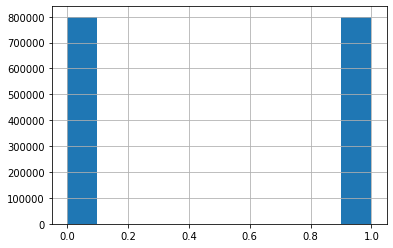

In [18]:
data['sentiment'].hist()

In [12]:
data['sentiment'].value_counts()

4    800000
0    800000
Name: sentiment, dtype: int64

In [13]:
data.loc[data['sentiment'] == 4, 'sentiment'] = 1

In [14]:
data['sentiment'].value_counts()

1    800000
0    800000
Name: sentiment, dtype: int64

In [15]:
data.head()

,text,sentiment
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


In [16]:
# Shuffle Data
data = data.sample(frac=1).reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   text       1600000 non-null  object
 1   sentiment  1600000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [20]:
data['len'] = data['text'].str.split().str.len()
data.head()

,text,sentiment,len
0,is back at school,0,4
1,"Gotta lay off the sugar, my Doc said i was dev...",0,23
2,I am doing NOTHING!!!!!!!!!,0,4
3,@joshrbarnes I would assume that the gym has a...,0,23
4,@tn_femme Music is life!!,1,4


In [21]:
# Train and Validation Split
msk = np.random.rand(len(data)) < 0.5
train_data = data[msk]
val_data = data[~msk]

In [22]:
print('Maximum review length: {}'.format(data['len'].max()))
print('Minimum review length: {}'.format(data['len'].min()))

Maximum review length: 64
Minimum review length: 1


In [23]:
# Create datasets 
train_text = train_data['text'].tolist()
# train_text = [' '.join(t.split()[0:150]) for t in train_text]
train_text = [' '.join(t.split()) for t in train_text]
train_text = np.array(train_text, dtype=object)[:, np.newaxis]
train_label = train_data['sentiment']

val_text = val_data['text'].tolist()
# val_text = [' '.join(t.split()[0:150]) for t in val_text]
val_text = [' '.join(t.split()) for t in val_text]
val_text = np.array(val_text, dtype=object)[:, np.newaxis]
val_label = val_data['sentiment']

In [24]:
print(len(train_text), len(train_label))
print(len(val_text), len(val_label))

799850 799850
800150 800150


In [25]:
train_text[0].shape

(1,)

In [26]:
set(train_label)

{0, 1}

In [27]:
USE = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", trainable=False)

In [28]:
# This is useful to debug the issues with input shape: https://github.com/tensorflow/hub/issues/526
input_text = Input(shape=(), name='sent1',dtype=tf.string)
embedding = USE(input_text)
# dense1 = Dense(256, activation='relu')(embedding)
# dropout1 = Dropout(0.2)(dense1)
# dense2 = Dense(100, activation='relu')(dropout1)
dense2 = Dense(100, activation='relu')(embedding)
dropout2 = Dropout(0.2)(dense2)
pred = Dense(2, activation='softmax')(dropout2)
model = Model(inputs=[input_text], outputs=pred)

model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, dpi=100)

loss = tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(loss=loss, optimizer='adam', metrics=['accuracy'])

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sent1 (InputLayer)           [(None,)]                 0         
_________________________________________________________________
keras_layer (KerasLayer)     (None, 512)               256797824 
_________________________________________________________________
dense (Dense)                (None, 100)               51300     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 256,849,326
Trainable params: 51,502
Non-trainable params: 256,797,824
_________________________________________________________________


In [29]:
model.predict(tf.convert_to_tensor(["the cat is on the mat", "dogs are in the fog"]))

array([[0.49072278, 0.50927716],
       [0.4883126 , 0.51168746]], dtype=float32)

In [30]:
from tensorflow.keras.callbacks import EarlyStopping
# If validation error does not improve for 10 epochs, then terminate the training
es = EarlyStopping(min_delta=0,patience=3)

from tensorflow.keras.callbacks import ModelCheckpoint
# add a checkpoint to save the lowest validation loss
filepath = '.'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True, save_weights_only=False, 
                             mode='auto', save_frequency=1)

In [31]:
BATCH_SIZE = 256
EPOCHS = 2
history = model.fit(
    tf.convert_to_tensor(train_text), train_label,
    validation_data=(val_text, val_label),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[es] # , checkpoint]    
    )

Epoch 1/2
3125/3125 [==============================] - 169s 54ms/step - loss: 0.4525 - accuracy: 0.7866 - val_loss: 0.4363 - val_accuracy: 0.7948
Epoch 2/2
3125/3125 [==============================] - 165s 53ms/step - loss: 0.4347 - accuracy: 0.7968 - val_loss: 0.4286 - val_accuracy: 0.7993


In [32]:
predictions = model.predict(val_text)
predictions[:5]

array([[0.581533  , 0.41846696],
       [0.2745065 , 0.72549343],
       [0.68863904, 0.311361  ],
       [0.9379537 , 0.06204621],
       [0.33599165, 0.6640083 ]], dtype=float32)

In [33]:
predictions_max = tf.math.argmax(predictions, axis=1)
predictions_max[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 1, 0, 0, 1])>

In [35]:
val_label[0:5]

0     0
5     1
8     0
9     0
11    1
Name: sentiment, dtype: int64

In [36]:
m = tf.keras.metrics.Accuracy()
m.update_state(val_label, predictions_max)
m.result().numpy()

0.7992989

In [37]:
predictions

array([[0.581533  , 0.41846696],
       [0.2745065 , 0.72549343],
       [0.68863904, 0.311361  ],
       ...,
       [0.03989242, 0.9601076 ],
       [0.33834141, 0.6616586 ],
       [0.32673585, 0.6732641 ]], dtype=float32)